
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.18?urlpath=lab/tree/light_curve_flare.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/docs/tutorials).
- **Source files:**
[light_curve_flare.ipynb](../_static/notebooks/light_curve_flare.ipynb) |
[light_curve_flare.py](../_static/notebooks/light_curve_flare.py)
</div>


# Light curve - Flare

## Prerequisites:

- Understanding of how the light curve estimator works, please refer to the [light curve notebook](light_curve.ipynb).

## Context

Frequently, especially when studying flares of bright sources, it is necessary to explore the time behaviour of a source on short time scales, in particular on time scales shorter than observing runs.

A typical example is given by the flare of PKS 2155-304 during the night from July 29 to 30 2006. See the [following article](https://ui.adsabs.harvard.edu/abs/2009A%26A...502..749A/abstract).

**Objective: Compute the light curve of a PKS 2155-304 flare on 5 minutes time intervals, i.e. smaller than the duration of individual observations.**

## Proposed approach:

We have seen in the general presentation of the light curve estimator, see [light curve notebook](light_curve.ipynb), Gammapy produces datasets in a given time interval, by default that of the parent observation. To be able to produce datasets on smaller time steps, it is necessary to split the observations into the required time intervals. 

This is easily performed with the `select_time` method of `~gammapy.data.Observations`. If you pass it a list of time intervals it will produce a list of time filtered observations in a new `~gammapy.data.Observations` object. Data reduction can then be performed and will result in datasets defined on the required time intervals and light curve estimation can proceed directly.

In summary, we have to:

- Select relevant `~gammapy.data.Observations` from the `~gammapy.data.DataStore`
- Apply the time selection in our predefined time intervals to obtain a new `~gammapy.data.Observations`
- Perform the data reduction (in 1D or 3D)
- Define the source model
- Extract the light curve from the reduced dataset

Here, we will use the PKS 2155-304 observations from the H.E.S.S. first public test data release. We will use time intervals of 5 minutes duration. The tutorial is implemented with the intermediate level API.

## Setup 

As usual, we'll start with some general imports...

In [1]:
%matplotlib inline
import astropy.units as u
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.time import Time
from regions import CircleSkyRegion
from astropy.coordinates import Angle

import logging

log = logging.getLogger(__name__)

Now let's import gammapy specific classes and functions

In [2]:
from gammapy.data import DataStore
from gammapy.datasets import SpectrumDataset
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel
from gammapy.maps import MapAxis
from gammapy.estimators import LightCurveEstimator
from gammapy.makers import (
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
)

## Select the data

We first set the datastore.

In [3]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")

Now we select observations within 2 degrees of PKS 2155-304. 

In [4]:
target_position = SkyCoord(
    329.71693826 * u.deg, -30.2255890 * u.deg, frame="icrs"
)
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=target_position.ra,
    lat=target_position.dec,
    radius=2 * u.deg,
)
obs_ids = data_store.obs_table.select_observations(selection)["OBS_ID"]
observations = data_store.get_observations(obs_ids)
print(f"Number of selected observations : {len(observations)}")

Number of selected observations : 21


## Define time intervals
We create the list of time intervals. Each time interval is an `astropy.time.Time` object, containing a start and stop time.

In [5]:
t0 = Time("2006-07-29T20:30")
duration = 10 * u.min
n_time_bins = 35
times = t0 + np.arange(n_time_bins) * duration
time_intervals = [
    Time([tstart, tstop]) for tstart, tstop in zip(times[:-1], times[1:])
]
print(time_intervals[0].mjd)

[53945.85416667 53945.86111111]


## Filter the observations list in time intervals

Here we apply the list of time intervals to the observations with `~gammapy.data.Observations.select_time()`.

This will return a new list of Observations filtered by time_intervals. For each time interval, a new observation is created that convers the intersection of the GTIs and time interval. 

In [6]:
short_observations = observations.select_time(time_intervals)
# check that observations have been filtered
print(
    f"Number of observations after time filtering: {len(short_observations)}\n"
)
print(short_observations[1].gti)

Number of observations after time filtering: 44

GTI info:
- Number of GTIs: 1
- Duration: 600.0 s
- Start: 53945.861865555555 MET
- Start: 2006-07-29T20:41:05.184 (time standard: TT)
- Stop: 53945.86881 MET
- Stop: 2006-07-29T20:51:05.184 (time standard: TT)



As we can see, we have now observations of duration equal to the chosen time step.

Now data reduction and light curve extraction can proceed exactly as before.

## Building 1D datasets from the new observations

Here we will perform the data reduction in 1D with reflected regions.

*Beware, with small time intervals the background normalization with OFF regions might become problematic.*

### Defining the geometry

We define the energy axes. As usual, the true energy axis has to cover a wider range to ensure a good coverage of the measured energy range chosen. 

We need to define the ON extraction region. Its size follows typical spectral extraction regions for HESS analyses.

In [7]:
# Target definition
e_reco = MapAxis.from_energy_bounds(0.4, 20, 10, "TeV")
e_true = MapAxis.from_energy_bounds(0.1, 40, 20, "TeV", name="energy_true")

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

### Creation of the data reduction makers

We now create the dataset and background makers for the selected geometry.

In [8]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker()
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

### Creation of the datasets

Now we perform the actual data reduction in the time_intervals.

In [9]:
%%time
datasets = []

dataset_empty = SpectrumDataset.create(
    e_reco=e_reco, e_true=e_true, region=on_region
)

for obs in short_observations:
    dataset = dataset_maker.run(dataset_empty.copy(), obs)

    dataset_on_off = bkg_maker.run(dataset, obs)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
    datasets.append(dataset_on_off)

CPU times: user 18 s, sys: 552 ms, total: 18.6 s
Wall time: 18.7 s


## Define the Model

The actual flux will depend on the spectral shape assumed. For simplicity, we use the power law spectral model of index 3.4 used in the [reference paper](https://ui.adsabs.harvard.edu/abs/2009A%26A...502..749A/abstract).

Here we use only a spectral model in the `~gammapy.modeling.models.SkyModel` object.

In [10]:
spectral_model = PowerLawSpectralModel(
    index=3.4, amplitude=2e-11 * u.Unit("1 / (cm2 s TeV)"), reference=1 * u.TeV
)
spectral_model.parameters["index"].frozen = False

sky_model = SkyModel(
    spatial_model=None, spectral_model=spectral_model, name="pks2155"
)

### Assign to model to all datasets

We assign each dataset its spectral model

In [11]:
for dataset in datasets:
    dataset.models = sky_model

## Extract the light curve

We first create the `~gammapy.time.LightCurveEstimator` for the list of datasets we just produced. We give the estimator the name of the source component to be fitted.

In [12]:
lc_maker_1d = LightCurveEstimator(
    energy_edges=[0.7, 20] * u.TeV, source="pks2155"
)

We can now perform the light curve extraction itself. To compare with the [reference paper](https://ui.adsabs.harvard.edu/abs/2009A%26A...502..749A/abstract), we select the 0.7-20 TeV range.

In [13]:
%%time
lc_1d = lc_maker_1d.run(datasets)

CPU times: user 23.3 s, sys: 220 ms, total: 23.6 s
Wall time: 24.1 s


Finally we plot the result for the 1D lightcurve:

No handles with labels found to put in legend.


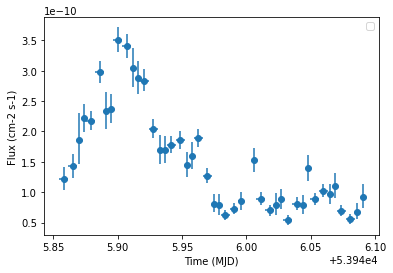

In [14]:
lc_1d.plot(marker="o")